In [1]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

## Functions to be used downstream in the workflow

In [2]:
makedatatree <- function(tree_file_bac,folder_stub_curr=folder_stub,
                         file_tax="taxonomy_dict_RF00177.csv",chosen_layout="circular") {
  tree_dict_bac <- read.csv(file.path(folder_stub_curr,file_tax))
  tree_dict_bac["Labels"] = tree_dict_bac["qseqid"]
  tree_dict_bac["Kingdom"] = tree_dict_bac["Clade"]
  tree_dict_bac = tree_dict_bac %>%
        dplyr::mutate(Metagenome = dplyr::case_when(grepl("rRNA",Labels) ~ "MG",
                                             TRUE ~ "Ref"))
  tip_label_df = data.frame("TipLabs" = tree_file_bac$tip.label)
  for (curr_ind in 1:nrow(tip_label_df)) {
      curr_splitter = unlist(strsplit(as.character(tip_label_df$TipLabs[curr_ind]),"\\|"))
      tip_label_df$TipLabs[curr_ind] = curr_splitter[length(curr_splitter)]
  }
  tree_dict_bac = tree_dict_bac %>%
    dplyr::mutate(Labels = gsub(":", "_", Labels)) %>%
    dplyr::mutate(Labels = gsub(",", "_", Labels)) %>%
    dplyr::mutate(Labels = gsub(";", "_", Labels)) %>%
    dplyr::mutate(Labels = gsub("=", "_", Labels)) %>%
    dplyr::filter(Labels %in% tip_label_df$TipLabs) %>%
    dplyr::inner_join(tip_label_df, by = c("Labels"="TipLabs"))
  distinct_cols <- c('#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                     '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
                     '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000',
                     '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080',
                     '#ffffff', '#000000')
  unique_phyla = unique(tree_dict_bac$Phylum)#$Kingdom)
  if (file_tax == "taxonomy_dict_RF00177.csv") {
    unique_phyla = unique(tree_dict_bac$Phylum)
  }
  distinct_cols <- colorRampPalette(distinct_cols)
  distinct_cols <- sample(distinct_cols(length(unique_phyla)))
  tree_file_bac <- as.phylo(ggtree(tree_file_bac,layout=chosen_layout))
  tree_bac_plot <- as.data.frame(tree_file_bac %>% fortify() %>%
                                   as_tibble())
  tree_bac_plot <- tree_bac_plot %>% dplyr::left_join(tree_dict_bac,by=c("label"="Labels"))
  
  unique_phyla = unique_phyla[unique_phyla != ""]
  tip_colors_bac <- lapply(unique_phyla, function(x)
  {tree_bac_plot$label[grepl(paste(x, collapse="|"),
                             tree_bac_plot$Kingdom)]})
  if (file_tax == "taxonomy_dict_RF00177.csv") {
    tip_colors_bac <- lapply(unique_phyla, function(x)
    {tree_bac_plot$label[grepl(paste(x, collapse="|"),
                               tree_bac_plot$Phylum)]})
  }
  names(tip_colors_bac) <- unique_phyla
  tip_colors_bac <- Filter(function(x) length(x) > 0, tip_colors_bac)
  tree_bac_toplot <- groupOTU(tree_file_bac, tip_colors_bac,
                              overlap="overwrite")
  data_tree_bac <- as.data.frame(ggtree(tree_bac_toplot)$data)
  
  data_tree_bac = data_tree_bac %>%
    dplyr::left_join(tree_dict_bac,by=c("label"="Labels")) %>%
    dplyr::mutate(Metagenome = 
                    dplyr::case_when(Metagenome  == "Ref" ~ "Ref",
                                     Metagenome == "MG" ~ "MG",
                                     TRUE ~ "None"))
  return(data_tree_bac)
}

In [3]:
final_data_tree_euk <- function(folder_in,model_in,cluster_all,tree_file="None") {
    folder_stub = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                            "refseq-DIAMOND", "tree-builder", folder_in)
    if (tree_file == "None") {
        tree_file <- read.tree(file.path(folder_stub,"iqtree_select",
                                             paste0("total_tree_",model_in,".treefile")))
    }
    
    tree_dict <- read.csv(file.path(folder_stub,paste0("taxonomy_dict_",model_in,".csv"))) %>%
        dplyr::mutate(Labels = vapply(strsplit(sapply(strsplit(as.character(vapply(strsplit(Labels,"SSU_"),
                                                                                   `[`, 1, 
                                            FUN.VALUE=character(1))), "\\|"), tail, 1),"\\."),`[`,
                                             1,FUN.VALUE=character(1)))

    data_tree <- as.data.frame(tree_file %>% fortify() %>% as_tibble())

    data_tree <- data_tree %>%
           dplyr::mutate(TipLab = vapply(strsplit(sapply(strsplit(as.character(vapply(strsplit(label,"SSU_"), `[`, 1, 
                                        FUN.VALUE=character(1))), "\\|"), tail, 1),"\\."),`[`,
                                         1,FUN.VALUE=character(1))) %>%
            dplyr::left_join(tree_dict, by = c("TipLab"="Labels")) %>% 
            dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
            dplyr::filter((type == "S") | (is.na(type)))

    data_tree$Phylum[(grepl("Eukar",tree_file$Domain)) ] = "Eukaryotic"

    data_tree$Metagenome = "Ref"
    data_tree$Metagenome[grepl("SSU",data_tree$label)] = "MG"
    data_tree$Metagenome[data_tree$Phylum == "Eukaryotic"] = "Outgroup"

    return(data_tree)
}

In [4]:
create_sam_meta <- function(samtools,metadata_file) {
    metadata_file["SampleDate"] = "1900-01-01"
    for (curr in 1:nrow(metadata_file)) {
        curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]
        
        if (grepl("ME", curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-ME"))
            curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
            sample_date = curr_token
        }
        if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "D"))
            sample_date = listed_meta[1]
            curr_token = sample_date
            if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

                listed_meta = unlist(strsplit(curr_token, "s"))
                sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
            } 
        } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } else if (!is.na(curr_token)) {
            listed_meta = unlist(strsplit(curr_token, "-"))
            sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
        } else {
            sample_date = ""
        }
        
        if (grepl("Fre",sample_date)) {
            sample_date = "Control"
        }
        if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
            sample_date = unlist(strsplit(sample_date,"D"))[1]
            
            if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

                sample_date = unlist(strsplit(sample_date, "s"))[1]
            }
            metadata_file$SampleDate[curr] = sample_date
        } else {
            metadata_file$SampleDate[curr] = sample_date
        }
        
        
    }
    
    sam_with_meta = samtools %>% dplyr::left_join(metadata_file %>% 
                                                  dplyr::mutate(SeqIDs = as.character(SeqIDs)),
                              by=c("Sample" = "SeqIDs"))
    return(sam_with_meta)
}

## Read in cluster files
- Filter the output by the OTUs that have more than 10 entries across the samples (clustered at 97%)
- Assign names for each one of the Lake Mendota 18S and 16S rRNA gene OTU clusters to be used to refer to each cluster

In [5]:
cluster_files = c("../../data/2021-11-07_treebuilder/clustered_contigs/reference.RF01960.clusters",
                  "../../data/2021-11-07_treebuilder/clustered_contigs/reference.RF00177.clusters")
cluster_all = data.frame()
for (cluster_file in cluster_files) {
    clust_f = read.csv(cluster_file,sep="\t",header=FALSE)
    colnames(clust_f)=c("type","clustnum","seqlen",
                        "percid","plus","a","b",
                        "aln","query","target")
    if (grepl("RF01960",cluster_file)) {
        clust_f["clustnum"] = -1*(as.numeric(clust_f$clustnum) + 1)
    }
    clust_f["Label"] = 0
    for (curr in 1:nrow(clust_f)) {
        if (clust_f$clustnum[curr] < 0) {
            clust_f[curr,"Label"] = paste0("MEND-TF-18S-",as.character(abs(clust_f[curr,"clustnum"])))
        } else {
            clust_f[curr,"Label"] = paste0("MEND-TF-16S-",as.character(abs(clust_f[curr,"clustnum"])))
        }
    }
    cluster_all = cluster_all %>% dplyr::bind_rows(clust_f)
}

In [6]:
write.csv(cluster_all,"../../data/clustered_id.txt",sep="\t")

Warning message in write.csv(cluster_all, "../../data/clustered_id.txt", sep = "\t"):
“attempt to set 'sep' ignored”


## Pair 16S &18S tree files with the data about each one of the sequences (taxonomy, etc.)

In [7]:
folder_stub = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                        "refseq-DIAMOND", "tree-builder", "2021-12-20_eukaryota")

tree_file_euk <- read.tree(file.path(folder_stub,"iqtree_select",
                                     "total_tree_RF01960.treefile"))
rooted.tree <- tree_file_euk

split_labs = c()
for (curr_lab in tree_file_euk$tip.label) {
    if (grepl("\\|", curr_lab)) {
        split_labs = c(split_labs,unlist(strsplit(curr_lab, "\\|"))[2])
    } else {
        split_labs = c(split_labs,unlist(strsplit(curr_lab, "\\|"))[1])
    }
}
tree_file_euk$tip.label = split_labs

tree_file_euk$edge.length[1] = 0.8

data_tree_euk = final_data_tree_euk("2021-12-20_eukaryota",model_in="RF01960",cluster_all=cluster_all,
                                    tree_file=tree_file_euk)

Warning message in if (tree_file == "None") {:
“the condition has length > 1 and only the first element will be used”


In [29]:
folder_stub_bact = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                        "refseq-DIAMOND", "tree-builder", "2021-12-19_bacteria")
tree_file_bact <- read.tree(file.path(folder_stub_bact,"iqtree_select",
                                     "total_tree_RF00177.treefile"))

tree_dict_bact <- read.csv(file.path(folder_stub_bact,"taxonomy_dict_RF00177.csv")) %>%
    dplyr::mutate(Labels = vapply(strsplit(sapply(strsplit(as.character(vapply(strsplit(Labels,"SSU_"), `[`, 1, 
                                        FUN.VALUE=character(1))), "\\|"), tail, 1),"\\."),`[`,
                                         1,FUN.VALUE=character(1)))

data_tree_bact <- as.data.frame(tree_file_bact %>% fortify() %>% as_tibble())

data_tree_bact <- data_tree_bact %>%
       dplyr::mutate(TipLab = vapply(strsplit(sapply(strsplit(as.character(vapply(strsplit(label,"SSU_"), `[`, 1, 
                                    FUN.VALUE=character(1))), "\\|"), tail, 1),"\\."),`[`,
                                     1,FUN.VALUE=character(1))) %>%
        dplyr::left_join(tree_dict_bact, by = c("TipLab"="Labels")) %>% 
        dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
        dplyr::filter((type == "S") | (is.na(type)))

data_tree_bact$Phylum[(grepl("Eukar",tree_file_bact$Domain)) ] = "Eukaryotic"

data_tree_bact$Metagenome = "Ref"
data_tree_bact$Metagenome[grepl("SSU",data_tree_bact$label)] = "MG"
data_tree_bact$Metagenome[data_tree_bact$Phylum == "Eukaryotic"] = "Outgroup"

In [30]:
unique(data_tree_bact$Order)

[1] NA                                   "Chitinophagales"                   
 [3] "Saprospirales"                      "Sphingobacteriales"                
 [5] "Cytophagales"                       "Bacteroidales"                     
 [7] "Flavobacteriales"                   "Marinilabiliales"                  
 [9] "Ignavibacteriales"                  "Chlorobiales"                      
[11] "Fimbriimonadales"                   "Armatimonadales"                   
[13] "Caldilineales"                      "Anaerolineales"                    
[15] "Chloroflexales"                     "Eubacteriales"                     
[17] "Synechococcales"                    "Sphingomonadales"                  
[19] "Desulfuromonadales"                 "Campylobacterales"                 
[21] "Nostocales"                         "Oscillatoriales"                   
[23] "Pleurocapsales"                     "Chroococcales"                     
[25] "Pseudanabaenales"                   "Vampirovibrionales"                
[27] "Gloeobacterales"                    "Spirochaetales"                    
[29] "Erysipelotrichales"                 "Entomoplasmatales"                 
[31] "Bacillales"                         "Acidimicrobiales"                  
[33] "Sporichthyales"                     "Micrococcales"                     
[35] "Acidothermales"                     "Geodermatophilales"                
[37] "Streptomycetales"                   "Corynebacteriales"                 
[39] "Solirubrobacterales"                "Gaiellales"                        
[41] "Verrucomicrobiales"                 "Terrimicrobiales"                  
[43] "Chthoniobacterales"                 "Verrucomicrobia incertae sedis"    
[45] "Opitutales"                         "Kiritimatiellales"                 
[47] "Parachlamydiales"                   "Pirellulales"                      
[49] "Gemmatales"                         "Isosphaerales"                     
[51] "Planctomycetales"                   "Phycisphaerales"                   
[53] "Gemmatimonadales"                   "Vicinamibacterales"                
[55] "Bryobacterales"                     "Blastocatellales"                  
[57] "Desulfobacterales"                  "Bdellovibrionales"                 
[59] "Myxococcales"                       "Hyphomicrobiales"                  
[61] "Rhodospirillales"                   "Bacteriovoracales"                 
[63] "Silvanigrellales"                   "Xanthomonadales"                   
[65] "Burkholderiales"                    "Nitrosomonadales"                  
[67] "Rhodocyclales"                      "Neisseriales"                      
[69] "Chromatiales"                       "Nevskiales"                        
[71] "Aeromonadales"                      "Moraxellales"                      
[73] "Pseudomonadales"                    "Cellvibrionales"                   
[75] "Gammaproteobacteria incertae sedis" "Methylococcales"                   
[77] "Rhodobacterales"                    "Caulobacterales"                   
[79] "Hyphomonadales"                     "Micropepsales"                     
[81] "Pelagibacterales"                   "Holosporales"                      
[83] "Rickettsiales"

In [16]:
head(data_tree_bact %>% dplyr::select(label,Phylum,Class,Order))

,label,Phylum,Class,Order
,<chr>,<chr>,<chr>,<chr>
1,000|JQ434475.1,NA,NA,NA
2,001|AF093495.1,NA,NA,NA
3,002|AF080098.1,NA,NA,NA
4,004|NR_152039.1,Bacteroidetes,Chitinophagia,Chitinophagales
5,198|NR_114255.1,Bacteroidetes,Chitinophagia,Chitinophagales
6,393|Ga0334988_0001741SSU_rRNA_bacteria,Bacteroidetes,Chitinophagia,Chitinophagales


In [73]:
cluster_all %>% dplyr::filter(Label == "MEND-TF-16S-468")

type,clustnum,seqlen,percid,plus,a,b,aln,query,target,Label
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
S,468,1527,*,*,*,*,*,Ga0335021_0032158SSU_rRNA_bacteria,*,MEND-TF-16S-468
H,468,1527,99.5,+,0,0,I1526MD,Ga0335067_0001428SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468
H,468,1527,99.9,+,0,0,1527M,Ga0453186_0005453SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468
H,468,1527,99.9,+,0,0,1527M,Ga0453917_0001157SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468
H,468,1527,99.9,+,0,0,1527M,Ga0453949_0002120SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468
H,468,1527,99.9,+,0,0,1527M,Ga0453954_0003107SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468
H,468,1383,100.0,+,0,0,=,Ga0334999_0124367SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468
H,468,850,100.0,+,0,0,=,Ga0453212_0433900SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468
H,468,822,100.0,+,0,0,=,Ga0453156_0299381SSU_rRNA_bacteria,Ga0335021_0032158SSU_rRNA_bacteria,MEND-TF-16S-468


In [75]:
tree_dict_bact %>% dplyr::filter(qseqid == "Ga0335021_0032158SSU_rRNA_bacteria")

Labels,qseqid,Lineage,TopLevel,Domain,Group,Clade,Phylum,Order,Family,Genus,Species,Class,Subfamily,SpeciesGroup
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


## Read in abundances from coverage files

In [40]:
## read in coverage files ##
directory_cov = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                          "mlp-out-12May","Mendota18SCoverage_122921")

list.files(directory_cov)
print("SAM reading")
# Read in coverage files
samtools = data.frame()
for (samfile in list.files(directory_cov)) {
    sam_curr = read.csv(file.path(directory_cov,samfile),sep="\t")
    print(paste("Processing...",samfile,sep=" "))
    # calculate tpm for each entry.
    tpm_Avals = sam_curr$numreads * 10^3 / sam_curr$endpos
    Sigma_A = sum(tpm_Avals)
    sam_curr["TPM"] = (tpm_Avals * 10^6) / Sigma_A
    sam_curr["Sample"] = unlist(strsplit(samfile,"\\."))[1]
    samtools = samtools %>% dplyr::bind_rows(sam_curr)

}

print("Processing SAM files...")
samtools["AssemblyName"] = ""
for (curr in 1:nrow(samtools)) {
    samtools$AssemblyName[curr] = unlist(strsplit(samtools$X.rname[curr], "_"))[1]
}

total_reads = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                       "read_number.csv")) %>%
        dplyr::rename(c("Sample" = "SeqProjID", "totalreads"="NumReads")) 
print("Merging num reads with total...")
print(nrow(samtools))
samtools = samtools %>% dplyr::left_join(total_reads %>% dplyr::mutate(Sample = as.character(Sample)))
samtools["propreads"] = samtools$numreads / samtools$totalreads

[1] "1229872.cov" "1229873.cov" "1229874.cov" "1229875.cov" "1229876.cov"
  [6] "1229877.cov" "1229878.cov" "1229879.cov" "1229880.cov" "1229881.cov"
 [11] "1229882.cov" "1229883.cov" "1229884.cov" "1229885.cov" "1229886.cov"
 [16] "1229887.cov" "1229888.cov" "1229889.cov" "1229890.cov" "1229891.cov"
 [21] "1229892.cov" "1229893.cov" "1229894.cov" "1229895.cov" "1229896.cov"
 [26] "1229897.cov" "1229898.cov" "1229899.cov" "1229901.cov" "1229902.cov"
 [31] "1229903.cov" "1229905.cov" "1229906.cov" "1229907.cov" "1229908.cov"
 [36] "1229909.cov" "1229910.cov" "1229911.cov" "1229912.cov" "1229913.cov"
 [41] "1229914.cov" "1229915.cov" "1229916.cov" "1229917.cov" "1229918.cov"
 [46] "1229919.cov" "1229920.cov" "1229921.cov" "1229922.cov" "1229923.cov"
 [51] "1229924.cov" "1229925.cov" "1229926.cov" "1229928.cov" "1229930.cov"
 [56] "1229935.cov" "1229936.cov" "1229937.cov" "1229938.cov" "1229939.cov"
 [61] "1229940.cov" "1229941.cov" "1229942.cov" "1229943.cov" "1229944.cov"
 [66] "1229945.cov" "1229946.cov" "1229947.cov" "1229948.cov" "1229949.cov"
 [71] "1229950.cov" "1229951.cov" "1229952.cov" "1229953.cov" "1229954.cov"
 [76] "1229955.cov" "1229956.cov" "1231375.cov" "1262967.cov" "1262968.cov"
 [81] "1262969.cov" "1262970.cov" "1262971.cov" "1262972.cov" "1262973.cov"
 [86] "1262974.cov" "1262975.cov" "1262976.cov" "1262977.cov" "1262978.cov"
 [91] "1262979.cov" "1262980.cov" "1262981.cov" "1262982.cov" "1262983.cov"
 [96] "1262984.cov" "1262985.cov" "1262986.cov" "1262987.cov" "1262988.cov"
[101] "1262989.cov" "1262990.cov" "1262991.cov" "1262992.cov" "1263005.cov"
[106] "1263008.cov" "1263014.cov" "1263036.cov" "1263037.cov" "1263038.cov"
[111] "1263039.cov" "1263040.cov" "1263041.cov" "1263042.cov" "1263043.cov"
[116] "1263047.cov" "1263048.cov" "1263056.cov" "1263306.cov" "1263307.cov"
[121] "1263308.cov" "1263309.cov" "1263310.cov" "1263311.cov" "1263312.cov"
[126] "1263313.cov" "1263314.cov" "1263316.cov" "1263317.cov" "1263318.cov"
[131] "1263320.cov" "1263321.cov" "1263322.cov" "1263323.cov" "1263324.cov"
[136] "1263325.cov" "1263326.cov" "1263327.cov" "1263328.cov" "1263329.cov"
[141] "1263330.cov" "1263331.cov" "1263332.cov" "1263333.cov" "1263334.cov"
[146] "1263335.cov" "1263336.cov" "1263337.cov" "1263338.cov" "1263339.cov"
[151] "1263340.cov" "1263341.cov" "1263342.cov" "1263343.cov" "1263344.cov"
[156] "1263345.cov" "1263346.cov" "1263347.cov" "1263348.cov" "1263349.cov"
[161] "1263350.cov" "1263351.cov" "1263352.cov" "1263353.cov" "1263354.cov"
[166] "1263355.cov" "1263356.cov" "1263357.cov" "1263358.cov" "1263359.cov"
[171] "1263360.cov" "1263361.cov" "1263362.cov" "1263363.cov" "1263364.cov"
[176] "1263365.cov" "1263366.cov" "1263367.cov" "1263368.cov" "1263369.cov"
[181] "1263370.cov" "1263371.cov" "1263372.cov" "1263373.cov" "1263374.cov"
[186] "1263375.cov" "1263376.cov" "1263377.cov" "1263378.cov" "1263379.cov"
[191] "1263380.cov" "1263381.cov" "1263382.cov" "1263383.cov" "1263384.cov"
[196] "1263385.cov" "1263386.cov" "1263387.cov" "1263388.cov" "1263389.cov"
[201] "1263390.cov" "1263391.cov" "1263392.cov" "1263393.cov" "1263394.cov"
[206] "1263395.cov" "1263396.cov" "1263397.cov" "1263582.cov" "1263583.cov"
[211] "1263584.cov" "1263585.cov" "1263586.cov" "1263587.cov" "1263588.cov"
[216] "1263589.cov" "1263590.cov" "1263591.cov" "1263592.cov" "1263593.cov"
[221] "1263594.cov" "1263595.cov" "1263596.cov" "1263597.cov" "1263598.cov"
[226] "1263599.cov" "1263600.cov" "1263601.cov" "1263602.cov" "1263603.cov"
[231] "1263604.cov" "1263605.cov" "1263606.cov" "1263607.cov" "1263608.cov"
[236] "1263609.cov" "1263610.cov" "1263611.cov" "1263612.cov" "1263613.cov"
[241] "1263614.cov" "1263615.cov" "1263616.cov" "1263617.cov" "1263618.cov"
[246] "1263619.cov" "1263620.cov" "1263622.cov" "1263623.cov" "1263624.cov"
[251] "1263625.cov" "1263626.cov" "1263627.cov" "1263628.cov" "1263630.cov"
[256] "1263631.cov" "1263632.cov" "1263633.cov" "1263634.cov" "1263635.cov"
[261] "1263636.cov" "1263637.cov" "1263638.cov" "1

[1] "SAM reading"
[1] "Processing... 1229872.cov"
[1] "Processing... 1229873.cov"
[1] "Processing... 1229874.cov"
[1] "Processing... 1229875.cov"
[1] "Processing... 1229876.cov"
[1] "Processing... 1229877.cov"
[1] "Processing... 1229878.cov"
[1] "Processing... 1229879.cov"
[1] "Processing... 1229880.cov"
[1] "Processing... 1229881.cov"
[1] "Processing... 1229882.cov"
[1] "Processing... 1229883.cov"
[1] "Processing... 1229884.cov"
[1] "Processing... 1229885.cov"
[1] "Processing... 1229886.cov"
[1] "Processing... 1229887.cov"
[1] "Processing... 1229888.cov"
[1] "Processing... 1229889.cov"
[1] "Processing... 1229890.cov"
[1] "Processing... 1229891.cov"
[1] "Processing... 1229892.cov"
[1] "Processing... 1229893.cov"
[1] "Processing... 1229894.cov"
[1] "Processing... 1229895.cov"
[1] "Processing... 1229896.cov"
[1] "Processing... 1229897.cov"
[1] "Processing... 1229898.cov"
[1] "Processing... 1229899.cov"
[1] "Processing... 1229901.cov"
[1] "Processing... 1229902.cov"
[1] "Processing... 122

[1] "Processing SAM files..."
[1] "Merging num reads with total..."
[1] 195738


Joining, by = "Sample"



In [31]:
## read in coverage files ##
directory_cov = file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                          "mlp-out-12May","Mendota16SCoverage_22Dec")

list.files(directory_cov)
print("SAM reading")
# Read in coverage files
samtools_bact = data.frame()
for (samfile in list.files(directory_cov)) {
    sam_curr = read.csv(file.path(directory_cov,samfile),sep="\t")
    #sam_curr = pd.concat([sam_curr,pd.read_csv(os.path.join(samdir16s,samfile16s),sep="\t")])
    print(paste("Processing...",samfile,sep=" "))
    # calculate tpm for each entry.
    tpm_Avals = sam_curr$numreads * 10^3 / sam_curr$endpos
    Sigma_A = sum(tpm_Avals)
    sam_curr["TPM"] = (tpm_Avals * 10^6) / Sigma_A
    sam_curr["Sample"] = unlist(strsplit(samfile,"\\."))[1]
    #sam_curr.reset_index(inplace=True)
    samtools_bact = samtools_bact %>% dplyr::bind_rows(sam_curr)

}

print("Processing SAM files...")
samtools_bact = samtools_bact %>%
    dplyr::mutate(AssemblyName = dplyr::case_when(grepl("\\|",samtools_bact$X.rname[curr]) ~ unlist(strsplit(unlist(strsplit(X.rname[curr],
                                                                          "_"))[1], "\\|"))[2],
                                                  TRUE ~ unlist(strsplit(unlist(strsplit(X.rname[curr],
                                                                          "_"))[1], "\\|"))[1]))

total_reads_bact = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                            "read_number.csv")) %>%
        dplyr::rename(c("Sample" = "SeqProjID", "totalreads"="NumReads")) 
print("Merging num reads with total...")
print(nrow(samtools_bact))
samtools_bact = samtools_bact %>% dplyr::left_join(total_reads_bact %>%
                                                   dplyr::mutate(Sample = as.character(Sample)))
samtools_bact["propreads"] = samtools_bact$numreads / samtools_bact$totalreads

[1] "1229872.cov" "1229873.cov" "1229874.cov" "1229875.cov" "1229876.cov"
  [6] "1229877.cov" "1229878.cov" "1229879.cov" "1229880.cov" "1229881.cov"
 [11] "1229882.cov" "1229883.cov" "1229884.cov" "1229885.cov" "1229886.cov"
 [16] "1229887.cov" "1229888.cov" "1229889.cov" "1229890.cov" "1229891.cov"
 [21] "1229892.cov" "1229893.cov" "1229894.cov" "1229895.cov" "1229896.cov"
 [26] "1229897.cov" "1229898.cov" "1229899.cov" "1229901.cov" "1229902.cov"
 [31] "1229903.cov" "1229905.cov" "1229906.cov" "1229907.cov" "1229908.cov"
 [36] "1229909.cov" "1229910.cov" "1229911.cov" "1229912.cov" "1229913.cov"
 [41] "1229914.cov" "1229915.cov" "1229916.cov" "1229917.cov" "1229918.cov"
 [46] "1229919.cov" "1229920.cov" "1229921.cov" "1229922.cov" "1229923.cov"
 [51] "1229924.cov" "1229925.cov" "1229926.cov" "1229928.cov" "1229930.cov"
 [56] "1229935.cov" "1229936.cov" "1229937.cov" "1229938.cov" "1229939.cov"
 [61] "1229940.cov" "1229941.cov" "1229942.cov" "1229943.cov" "1229944.cov"
 [66] "1229945.cov" "1229946.cov" "1229947.cov" "1229948.cov" "1229949.cov"
 [71] "1229950.cov" "1229951.cov" "1229952.cov" "1229953.cov" "1229954.cov"
 [76] "1229955.cov" "1229956.cov" "1231375.cov" "1262967.cov" "1262968.cov"
 [81] "1262969.cov" "1262970.cov" "1262971.cov" "1262972.cov" "1262973.cov"
 [86] "1262974.cov" "1262975.cov" "1262976.cov" "1262977.cov" "1262978.cov"
 [91] "1262979.cov" "1262980.cov" "1262981.cov" "1262982.cov" "1262983.cov"
 [96] "1262984.cov" "1262985.cov" "1262986.cov" "1262987.cov" "1262988.cov"
[101] "1262989.cov" "1262990.cov" "1262991.cov" "1262992.cov" "1263005.cov"
[106] "1263008.cov" "1263014.cov" "1263036.cov" "1263037.cov" "1263038.cov"
[111] "1263039.cov" "1263040.cov" "1263041.cov" "1263042.cov" "1263043.cov"
[116] "1263047.cov" "1263048.cov" "1263056.cov" "1263306.cov" "1263307.cov"
[121] "1263308.cov" "1263309.cov" "1263310.cov" "1263311.cov" "1263312.cov"
[126] "1263313.cov" "1263314.cov" "1263316.cov" "1263317.cov" "1263318.cov"
[131] "1263320.cov" "1263321.cov" "1263322.cov" "1263323.cov" "1263324.cov"
[136] "1263325.cov" "1263326.cov" "1263327.cov" "1263328.cov" "1263329.cov"
[141] "1263330.cov" "1263331.cov" "1263332.cov" "1263333.cov" "1263334.cov"
[146] "1263335.cov" "1263336.cov" "1263337.cov" "1263338.cov" "1263339.cov"
[151] "1263340.cov" "1263341.cov" "1263342.cov" "1263343.cov" "1263344.cov"
[156] "1263345.cov" "1263346.cov" "1263347.cov" "1263348.cov" "1263349.cov"
[161] "1263350.cov" "1263351.cov" "1263352.cov" "1263353.cov" "1263354.cov"
[166] "1263355.cov" "1263356.cov" "1263357.cov" "1263358.cov" "1263359.cov"
[171] "1263360.cov" "1263361.cov" "1263362.cov" "1263363.cov" "1263364.cov"
[176] "1263365.cov" "1263366.cov" "1263367.cov" "1263368.cov" "1263369.cov"
[181] "1263370.cov" "1263371.cov" "1263372.cov" "1263373.cov" "1263374.cov"
[186] "1263375.cov" "1263376.cov" "1263377.cov" "1263378.cov" "1263379.cov"
[191] "1263380.cov" "1263381.cov" "1263382.cov" "1263383.cov" "1263384.cov"
[196] "1263385.cov" "1263386.cov" "1263387.cov" "1263388.cov" "1263389.cov"
[201] "1263390.cov" "1263391.cov" "1263392.cov" "1263393.cov" "1263394.cov"
[206] "1263395.cov" "1263396.cov" "1263397.cov" "1263582.cov" "1263583.cov"
[211] "1263584.cov" "1263585.cov" "1263586.cov" "1263587.cov" "1263588.cov"
[216] "1263589.cov" "1263590.cov" "1263591.cov" "1263592.cov" "1263593.cov"
[221] "1263594.cov" "1263595.cov" "1263596.cov" "1263597.cov" "1263598.cov"
[226] "1263599.cov" "1263600.cov" "1263601.cov" "1263602.cov" "1263603.cov"
[231] "1263604.cov" "1263605.cov" "1263606.cov" "1263607.cov" "1263608.cov"
[236] "1263609.cov" "1263610.cov" "1263611.cov" "1263612.cov" "1263613.cov"
[241] "1263614.cov" "1263615.cov" "1263616.cov" "1263617.cov" "1263618.cov"
[246] "1263619.cov" "1263620.cov" "1263622.cov" "1263623.cov" "1263624.cov"
[251] "1263625.cov" "1263626.cov" "1263627.cov" "1263628.cov" "1263630.cov"
[256] "1263631.cov" "1263632.cov" "1263633.cov" "1263634.cov" "1263635.cov"
[261] "1263636.cov" "1263637.cov" "1263638.cov" "1

[1] "SAM reading"
[1] "Processing... 1229872.cov"
[1] "Processing... 1229873.cov"
[1] "Processing... 1229874.cov"
[1] "Processing... 1229875.cov"
[1] "Processing... 1229876.cov"
[1] "Processing... 1229877.cov"
[1] "Processing... 1229878.cov"
[1] "Processing... 1229879.cov"
[1] "Processing... 1229880.cov"
[1] "Processing... 1229881.cov"
[1] "Processing... 1229882.cov"
[1] "Processing... 1229883.cov"
[1] "Processing... 1229884.cov"
[1] "Processing... 1229885.cov"
[1] "Processing... 1229886.cov"
[1] "Processing... 1229887.cov"
[1] "Processing... 1229888.cov"
[1] "Processing... 1229889.cov"
[1] "Processing... 1229890.cov"
[1] "Processing... 1229891.cov"
[1] "Processing... 1229892.cov"
[1] "Processing... 1229893.cov"
[1] "Processing... 1229894.cov"
[1] "Processing... 1229895.cov"
[1] "Processing... 1229896.cov"
[1] "Processing... 1229897.cov"
[1] "Processing... 1229898.cov"
[1] "Processing... 1229899.cov"
[1] "Processing... 1229901.cov"
[1] "Processing... 1229902.cov"
[1] "Processing... 122

[1] "Processing SAM files..."
[1] "Merging num reads with total..."
[1] 977398


Joining, by = "Sample"



## Link abundance files with metadata

In [9]:
metadata_file = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                   "meta-lakes/meta-lakes-pipeline/data/all_metadata_12May.csv"))

In [41]:
## These are summed reads mapped when mapping is done with raw reads back to the full metaSPAdes
## assembly for the sample & only originally clustered rRNA contigs are used, rather than
## using only the 16S and 18S rRNA genes as the query sequences and calculating TPM using those
## sequences.
samtools_assembly=read.csv("../../data/rrna_abund_frame.csv") %>%
    dplyr::mutate(Sample=as.character(SeqProjID)) %>%
    dplyr::group_by(Label,Sample) %>% dplyr::summarize(TPM=sum(TPM,na.rm=TRUE))

`summarise()` has grouped output by 'Label'. You can override using the `.groups` argument.



In [46]:
sam_with_meta_filt_assembly = create_sam_meta(samtools_assembly,metadata_file)

In [43]:
cluster_occurrences = cluster_all %>% group_by(Label) %>% dplyr::tally()


cluster_occurrences = cluster_all %>% group_by(Label) %>% dplyr::tally()
sam_with_meta_filt =   create_sam_meta(samtools,metadata_file) %>%
                   dplyr::mutate(X.rname = vapply(strsplit(X.rname,"SSU"), 
                                                `[`, 1, 
                                                FUN.VALUE=character(1))) %>% 
                   dplyr::inner_join(cluster_all %>% dplyr::left_join(cluster_occurrences) %>%
                                                       dplyr::filter(n >= 10) %>%
                                                       dplyr::filter(grepl("eukary",query)) %>%
                                                       dplyr::mutate(query = vapply(strsplit(query,"SSU"), 
                                                                                    `[`, 1, 
                                                                                    FUN.VALUE=character(1))),
                                                 by = c("X.rname" = "query"))

sam_with_meta <- create_sam_meta(samtools,metadata_file) %>%
    dplyr::left_join(cluster_all,by=c("X.rname"="query"))

Joining, by = "Label"



In [47]:
head(sam_with_meta_filt_assembly)

Label,Sample,TPM,X,AnalysisIDs,Assembly,Raw,SeqProjID,Analysis.Project.GOLD.Analysis.Project.ID,Analysis.Project.Analysis.Project.Name,Analysis.Project.Analysis.Project.Type,Analysis.Project.IMG.Submission.ID,Analysis.Project.Assembly.Method,Analysis.Project.Add.Date,Analysis.Project.IMG.Taxon.ID,Analysis.Project.ITS.Analysis.Project.ID,SampleDate
<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<int>,<chr>
MEND-TF-16S-0,1229872,0,39,1229697,/global/dna/dm_archive/img/submissions/209661/Ga0334983_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226251/12844.1.289902.CCAGTGTT-AACACTGG.filter-METAGENOME.fastq.gz,1229872,Ga0334983,"Freshwater microbial communities from Lake Mendota, Madison, Wisconsin, United States - TYMEFLIES-ME16May2013-rr0016",Metagenome Analysis,209661,metaspades v. 3.13.0,2018-12-13,3300034060,1229697,16May2013
MEND-TF-16S-0,1229873,0,67,1229699,/global/dna/dm_archive/img/submissions/209662/Ga0334984_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226252/12844.1.289902.TGTACACC-GGTGTACA.filter-METAGENOME.fastq.gz,1229873,Ga0334984,"Freshwater microbial communities from Lake Mendota, Madison, Wisconsin, United States - TYMEFLIES-ME13Sep2014-rr0020",Metagenome Analysis,209662,metaspades v. 3.13.0,2018-12-13,3300035665,1229699,13Sep2014
MEND-TF-16S-0,1229874,0,311,1229701,/global/dna/dm_archive/img/submissions/209663/Ga0334985_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226253/12844.1.289902.TCGCTGTT-AACAGCGA.filter-METAGENOME.fastq.gz,1229874,Ga0334985,"Freshwater microbial communities from Lake Mendota, Madison, Wisconsin, United States - TYMEFLIES-ME04Jul2014-rr0021",Metagenome Analysis,209663,metaspades v. 3.13.0,2018-12-13,3300034018,1229701,04Jul2014
MEND-TF-16S-0,1229875,0,163,1229703,/global/dna/dm_archive/img/submissions/209664/Ga0334986_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226258/12844.1.289902.AGCTAACC-GGTTAGCT.filter-METAGENOME.fastq.gz,1229875,Ga0334986,"Freshwater microbial communities from Lake Mendota, Madison, Wisconsin, United States - TYMEFLIES-ME18Aug2017-rr0027",Metagenome Analysis,209664,metaspades v. 3.13.0,2018-12-13,3300034012,1229703,18Aug2017
MEND-TF-16S-0,1229876,0,18,1229705,/global/dna/dm_archive/img/submissions/209665/Ga0334987_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226259/12844.1.289902.GGACTGTT-AACAGTCC.filter-METAGENOME.fastq.gz,1229876,Ga0334987,"Freshwater microbial communities from Lake Mendota, Madison, Wisconsin, United States - TYMEFLIES-ME02Sep2004-rr0028",Metagenome Analysis,209665,metaspades v. 3.13.0,2018-12-13,3300034061,1229705,02Sep2004
MEND-TF-16S-0,1229877,0,103,1229707,/global/dna/dm_archive/img/submissions/209666/Ga0334988_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226260/12844.1.289902.ACGGAACA-TGTTCCGT.filter-METAGENOME.fastq.gz,1229877,Ga0334988,"Freshwater microbial communities from Lake Mendota, Madison, Wisconsin, United States - TYMEFLIES-ME18Aug2006D6-rr0029",Metagenome Analysis,209666,metaspades v. 3.13.0,2018-12-13,3300036398,1229707,18Aug2006


`geom_smooth()` using formula 'y ~ x'



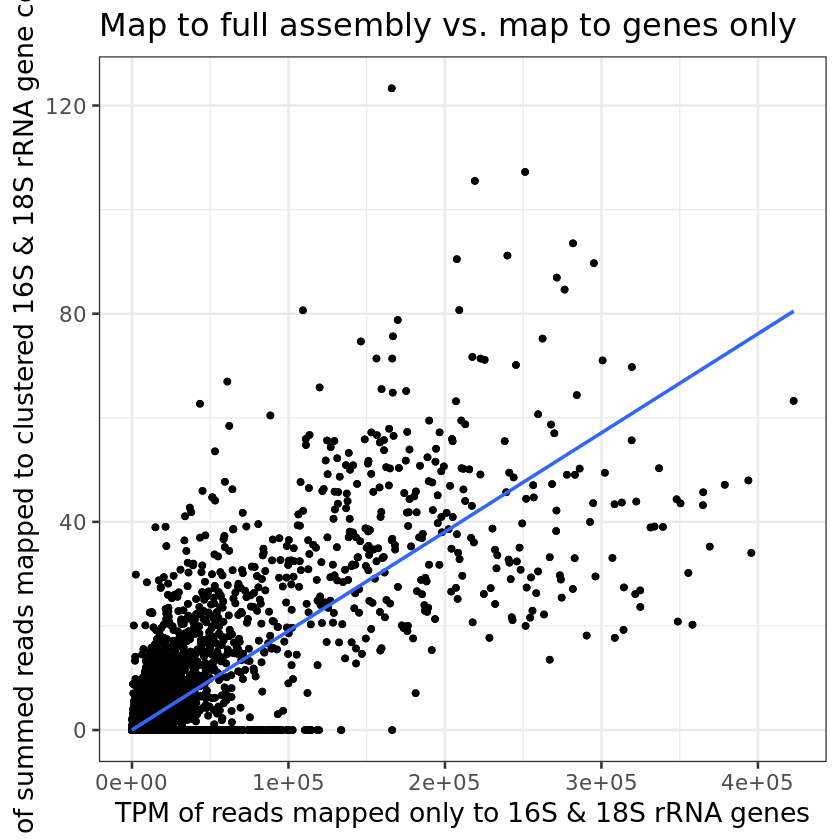

In [51]:
combined_frames = sam_with_meta_filt %>% dplyr::mutate(Sample=as.numeric(Sample)) %>% 
    dplyr::left_join(sam_with_meta_filt_assembly %>% 
                     dplyr::mutate(Sample=as.numeric(Sample))%>% 
                     dplyr::rename(c("AssemblyTPM"="TPM")),
                                       by = c("Sample","Label","Assembly","Raw",
                                             "SeqProjID","SampleDate"))
ggplot(combined_frames) + 
    geom_point(aes(x=TPM,y=AssemblyTPM)) + geom_smooth(aes(y=AssemblyTPM,x=TPM),method="lm") + 
    theme_bw(base_size=16) + xlab("TPM of reads mapped only to 16S & 18S rRNA genes") + 
    ylab("TPM of summed reads mapped to clustered 16S & 18S rRNA gene contigs") + 
    ggtitle("Map to full assembly vs. map to genes only")

In [54]:
summary(lm(AssemblyTPM ~ TPM,data=combined_frames))


Call:
lm(formula = AssemblyTPM ~ TPM, data = combined_frames)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.956  -0.198  -0.053  -0.026  91.694 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.564e-02  1.092e-02   2.348   0.0189 *  
TPM         1.903e-04  5.042e-07 377.420   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.835 on 70412 degrees of freedom
Multiple R-squared:  0.6692,	Adjusted R-squared:  0.6692 
F-statistic: 1.424e+05 on 1 and 70412 DF,  p-value: < 2.2e-16


In [33]:
cluster_occurrences = cluster_all %>% group_by(Label) %>% dplyr::tally()
sam_with_meta_bact_filt =  create_sam_meta(samtools_bact,metadata_file) %>%
                   dplyr::mutate(X.rname = vapply(strsplit(X.rname,"SSU"), 
                                                `[`, 1, 
                                                FUN.VALUE=character(1))) %>% 
                   dplyr::inner_join(cluster_all %>% dplyr::left_join(cluster_occurrences) %>%
                                                       dplyr::filter(n >= 10) %>%
                                                       dplyr::filter(grepl("bacteria",query)) %>%
                                                       dplyr::mutate(query = vapply(strsplit(query,"SSU"), 
                                                                                    `[`, 1, 
                                                                                    FUN.VALUE=character(1))),
                                                 by = c("X.rname" = "query"))
                                     
                                     
sam_with_meta_bact <- create_sam_meta(samtools_bact,metadata_file) %>%
    dplyr::left_join(cluster_all,by=c("X.rname"="query"))

Joining, by = "Label"



In [33]:
abundance_df = (samtools %>% dplyr::left_join(metadata_file %>% 
                                            dplyr::mutate(SeqIDs = as.character(SeqIDs)),
                              by=c("Sample" = "SeqIDs")) %>% 
            dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label")) %>% dplyr::filter(TPM > 1000) %>% 
            dplyr::group_by(X.rname,Phylum) %>% dplyr::summarize(NumberHighAbund = dplyr::n()) %>%
            dplyr::rename(PhylumNew = Phylum))

abundance_df = abundance_df %>% dplyr::left_join(data_tree_euk %>% dplyr::select(label,x),
                                  by = c("X.rname"= "label"))

`summarise()` has grouped output by 'X.rname'. You can override using the `.groups` argument.



In [ ]:
write.csv(sam_with_meta, file.path("..","..","data","sam_with_meta_euk.csv"))

## Save output files for use in other notebooks

In [34]:
write.csv(sam_with_meta_bact, file.path("..","..","data","sam_with_meta_bact.csv"))
#write.csv(sam_with_meta, file.path("..","..","data","sam_with_meta_euk.csv"))

In [35]:
write.csv(sam_with_meta_bact_filt, file.path("..","..","data","sam_with_meta_bact_filt.csv"))
#write.csv(sam_with_meta_filt, file.path("..","..","data","sam_with_meta_euk_filt.csv"))

In [36]:
write.csv(data_tree_bact, file.path("..","..","data","data_tree_bact.csv"))
#write.csv(data_tree_euk, file.path("..","..","data","data_tree_euk.csv"))

In [66]:
sort(unique((data_tree_bact %>% dplyr::filter(grepl("-4",Label)))$Label))

[1] "MEND-TF-16S-400" "MEND-TF-16S-401" "MEND-TF-16S-402" "MEND-TF-16S-405"
 [5] "MEND-TF-16S-406" "MEND-TF-16S-409" "MEND-TF-16S-411" "MEND-TF-16S-412"
 [9] "MEND-TF-16S-413" "MEND-TF-16S-414" "MEND-TF-16S-415" "MEND-TF-16S-416"
[13] "MEND-TF-16S-417" "MEND-TF-16S-418" "MEND-TF-16S-419" "MEND-TF-16S-420"
[17] "MEND-TF-16S-421" "MEND-TF-16S-423" "MEND-TF-16S-424" "MEND-TF-16S-425"
[21] "MEND-TF-16S-426" "MEND-TF-16S-428" "MEND-TF-16S-43"  "MEND-TF-16S-431"
[25] "MEND-TF-16S-432" "MEND-TF-16S-433" "MEND-TF-16S-435" "MEND-TF-16S-436"
[29] "MEND-TF-16S-440" "MEND-TF-16S-442" "MEND-TF-16S-443" "MEND-TF-16S-444"
[33] "MEND-TF-16S-445" "MEND-TF-16S-447" "MEND-TF-16S-449" "MEND-TF-16S-450"
[37] "MEND-TF-16S-451" "MEND-TF-16S-452" "MEND-TF-16S-453" "MEND-TF-16S-457"
[41] "MEND-TF-16S-459" "MEND-TF-16S-460" "MEND-TF-16S-461" "MEND-TF-16S-462"
[45] "MEND-TF-16S-463" "MEND-TF-16S-464" "MEND-TF-16S-465" "MEND-TF-16S-466"
[49] "MEND-TF-16S-467" "MEND-TF-16S-469" "MEND-TF-16S-478" "MEND-TF-16S-481"
[53] "MEND-TF-16S-482" "MEND-TF-16S-483" "MEND-TF-16S-484" "MEND-TF-16S-485"
[57] "MEND-TF-16S-486" "MEND-TF-16S-489" "MEND-TF-16S-491" "MEND-TF-16S-492"
[61] "MEND-TF-16S-494" "MEND-TF-16S-495"

In [34]:
write.csv(abundance_df, file.path("..","..","data","abundance_df_euk.csv"))
#write.csv(data_tree_euk, file.path("..","..","data","data_tree_euk.csv"))